In [1]:
import cPickle
import numpy as np
import os

In [2]:
def load_data_batch(file):
    with open(file,'rb') as f:
        data = cPickle.load(f)
        f.close()
        X = data['data']
        Y = data['labels']
        X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y

def load_data(path):
    xs, ys = [], []
    for i in range(1,6):
        f = os.path.join(path,'data_batch_%d' % (i))
        X, Y = load_data_batch(f)
        xs.append(X)
        ys.append(Y)
    
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    del X, Y
    
    X_test, Y_test = load_data_batch(os.path.join(path,'test_batch'))
    
    return X_train,Y_train,X_test,Y_test

In [3]:
X_train,Y_train,X_test,Y_test = load_data("cs231n/datasets/cifar-10-batches-py")

print "Training X shape: ",X_train.shape
print "Training Y shape: ",Y_train.shape
print "Testing X shape: ",X_test.shape
print "Testing Y shape: ",Y_test.shape

Training X shape:  (50000, 32, 32, 3)
Training Y shape:  (50000,)
Testing X shape:  (10000, 32, 32, 3)
Testing Y shape:  (10000,)


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

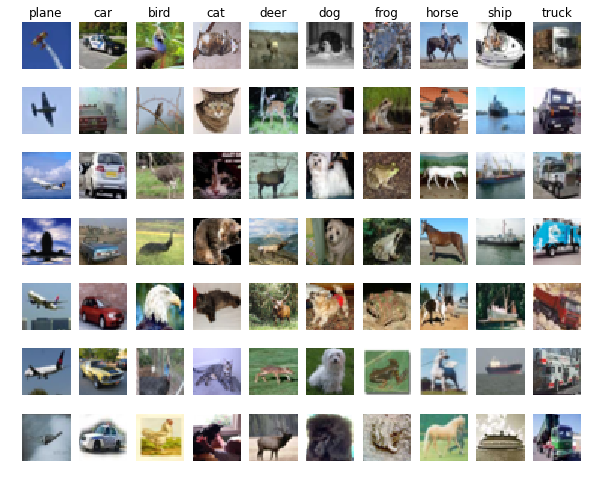

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train == y)
    idxs = np.random.choice(idxs,sample_per_class,replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class,num_classes,plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
num_training = 49000
num_validation = 1000
num_testing = 1000
num_dev = 500

mask = range(num_training,num_training + num_validation)
X_val = X_train[mask]
Y_val = Y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
Y_train = Y_train[mask]

mask = range(num_testing)
X_test = X_test[mask]
Y_test = Y_test[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
Y_dev = Y_train[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', Y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', Y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test = np.reshape(X_test,(X_test.shape[0],-1))
print X_train.shape,X_test.shape

X_val = np.reshape(X_val,(X_val.shape[0],-1))
X_dev = np.reshape(X_dev,(X_dev.shape[0],-1))
print X_val.shape,X_dev.shape

(49000, 3072) (1000, 3072)
(1000, 3072) (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


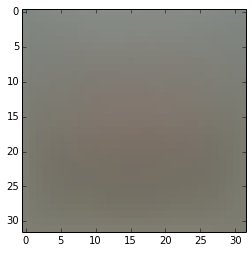

In [8]:
mean_image = np.mean(X_train,axis=0)
print mean_image[:10]

plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

In [9]:
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
X_train = np.hstack([X_train,np.ones((X_train.shape[0],1))])
X_val = np.hstack([X_val,np.ones((X_val.shape[0],1))])
X_test = np.hstack([X_test,np.ones((X_test.shape[0],1))])
X_dev = np.hstack([X_dev,np.ones((X_dev.shape[0],1))])

In [33]:
import SoftmaxLoss
reload(SoftmaxLoss)
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
start_time = time.time()
loss, grad = SoftmaxLoss.softmax_loss(W, X_dev, Y_dev, 0.0000001)
print 'loss: %f' % (loss, )
print 'time',time.time() - start_time

loss: 23.653132
time 0.0271570682526


In [34]:
# Check if svm_naive implementation and svm_vectorized implementation give same result
start_time = time.time()
naive_loss, grad_naive = SoftmaxLoss.softmax_loss_naive(W,X_dev,Y_dev,0.0000001)
end_time = time.time()
print 'Loss %f calculated in %s'%(naive_loss,str(end_time - start_time))

start_time = time.time()
vect_loss, grad_vectorized = SoftmaxLoss.softmax_loss(W,X_dev,Y_dev,0.0000001)
end_time = time.time()
print 'Loss %f calculated in %s'%(vect_loss,str(end_time - start_time))

print 'Naive Loss and Vectorized Loss: %f'%(vect_loss - naive_loss)
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Gradient Difference: %f' % difference

Loss 23.653132 calculated in 0.256494998932
Loss 23.653132 calculated in 0.0127868652344
Naive Loss and Vectorized Loss: 0.000000
Gradient Difference: 0.000000


In [35]:
# Stochastic Gradient Descent
import LinearClassifier
reload(LinearClassifier)

classifier = LinearClassifier.SoftmaxClassifier()
start_time = time.time()
loss_hist = classifier.train(X_train,Y_train,reg=1.)
end_time = time.time()

print 'Time taken to train the LinearSVM model: %s'%(str(end_time-start_time))

Time taken to train the LinearSVM model: 292.217297077


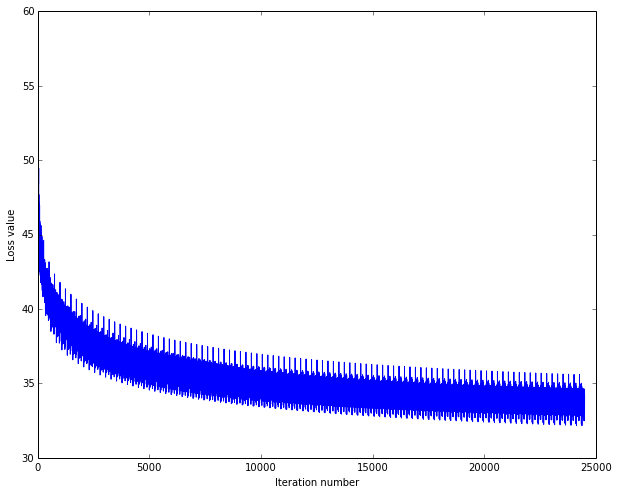

In [36]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [41]:
import LinearClassifier
reload(LinearClassifier)

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

start_time = time.time()
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        classifier = LinearClassifier.SoftmaxClassifier()
        loss_hist = classifier.train(X_train,Y_train,reg=reg,learning_rate=learning_rate)
        Y_val_pred = classifier.predict(X_val)
        accuracy = np.mean(Y_val == Y_val_pred)
        results[(learning_rate,reg)] = accuracy
        if accuracy > best_val:
            best_val = accuracy
            best_softmax = classifier
end_time = time.time()
print "Time taken for cross-validation: %s" % (end_time-start_time)

SoftmaxLoss.py:59: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(num/den[:,None]))/num_train
SoftmaxLoss.py:60: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (W**2).sum()
SoftmaxLoss.py:60: RuntimeWarning: overflow encountered in square
  loss += reg * (W**2).sum()
SoftmaxLoss.py:65: RuntimeWarning: overflow encountered in multiply
  dW = C.dot(X).T + reg * W


Time taken for cross-validation: 670.692782164


In [45]:
print 'best validation accuracy achieved during cross-validation: %f' % best_val

best validation accuracy achieved during cross-validation: 0.340000


In [43]:
# Prediction
Y_train_pred = best_softmax.predict(X_train)
print 'training accuracy: %f' % (np.mean(Y_train == Y_train_pred), )
Y_val_pred = best_softmax.predict(X_val)
print 'validation accuracy: %f' % (np.mean(Y_val == Y_val_pred), )
Y_test_pred = best_softmax.predict(X_test)
print 'testing accuracy: %f' % (np.mean(Y_test == Y_test_pred), )

training accuracy: 0.325796
validation accuracy: 0.340000
testing accuracy: 0.341000


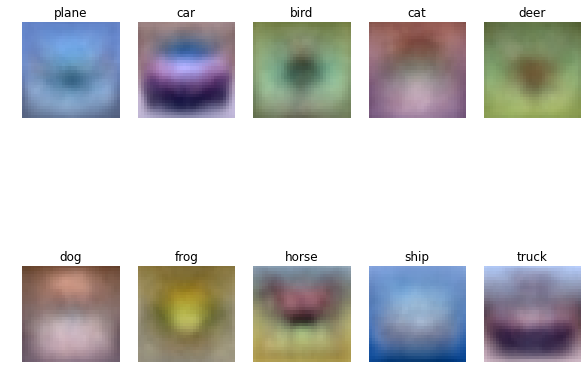

In [44]:
# Visualizing weights
W = best_softmax.W[:-1,:] # strip out the bias
W = W.reshape(32, 32, 3, 10)
W_min, W_max = np.min(W), np.max(W)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])